# Машинное обучение, ФКН ВШЭ

# Практическое задание 12. Несбалансированные задачи

## Общая информация
Дата выдачи: 26.04.2021

Мягкий дедлайн: 10.05.2021 00:59 MSK

Жёсткий дедлайн: 14.05.2021 00:59 MSK

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-xx-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

## О задании

В этом задании мы разберем основные техники работы в задачах, где один из классов занимает существенно меньшую долю выборки, чем остальные. Для простоты мы обойдемся бинарной задачей, тем не менее, во многом данные методы можно перенести и на задачи с б**о**льшим числом классов. Кроме того, вы получите очередной бесценный опыт исследования случайной библиотеки случайных индусов с нуля.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

from tqdm.auto import tqdm
%matplotlib inline 

**Задание -1 (1 балл)**. EDA

В качестве данных для нашей работы возьмем выложенный на kaggle датасет транзакций, в котором нужно выискивать мошеннические проводки: [клик](https://www.kaggle.com/mlg-ulb/creditcardfraud). Данная задача по определению подходит под несбалансированную, что можно сказать даже без наличия каких-либо данных (понятно, что среди всех транзакций клиентов очень малая часть будет мошеннической).

Загрузим данные, проведем некоторые классические манипуляции.

In [4]:
"""%%bash
kaggle datasets download -d mlg-ulb/creditcardfraud
unzip creditcardfraud.zip""";

In [2]:
df = pd.read_csv('creditcard.csv')

In [6]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


Наши данные были анонимизированы. Мы имеем 30 признаков, из которых 28 - это результаты PCA-преобразования на исходном датасете. Еще 2 признака представляют собой время в секундах, прошедшее с момента первой транзакции в датасете, и размер транзакции. Скажите, какова доля положительных объектов в выборке?

In [4]:
#your code here
np.mean(df.Class)

0.001727485630620034

Начнем с обработки времени. Секунды сами по себе не несут большой информации о зависимостях в данных, попробуйте по ним создать признаки "час" (от 0 до 23) и "день" (от 0 до ...) в аналогичной манере (принимая первый объект выборки за начальную точку). Сколько дней покрывают данные?

In [3]:
#your code here
df['hour'] = (df.Time / 3600).astype(int) % 24
df['day'] = (df.Time / 3600 / 24).astype(int)
df.day.unique() # 2 дня

array([0, 1])

Постройте следующие графики:

1. Распределение числа транзакций по каждому часу (line-plot).
2. Распределение доли мошеннических транзакций по каждому часу (line-plot)
3. То же самое для дней (здесь можно использовать bar-plot, так как дней должно быть немного).

Какие выводы можно сделать из графиков? На ваш взгляд, как можно связать полученные нами часы с реальными часами в сутках?

Text(0, 0.5, 'proportion of frauds')

<Figure size 1440x720 with 0 Axes>

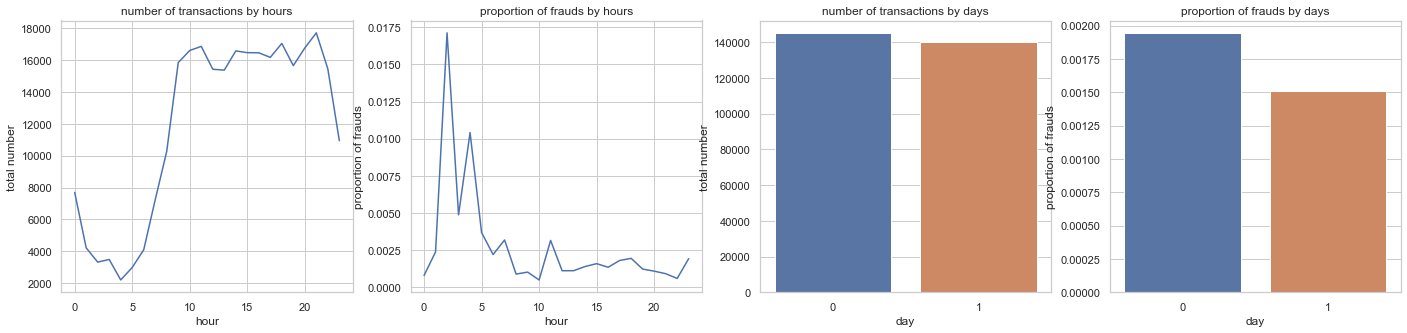

In [39]:
#your code here
plt.figure(figsize=(20, 10))
fig, axs = plt.subplots(ncols=4)
fig.set_size_inches((24, 5))

sns.lineplot(x=df.groupby('hour').count().index, y=df.groupby('hour').count().Class, ax=axs[0])
axs[0].set_title('number of transactions by hours')
axs[0].set_ylabel('total number')

sns.lineplot(x=df.groupby('hour').mean().index, y=df.groupby('hour').mean().Class, ax=axs[1])
axs[1].set_title('proportion of frauds by hours')
axs[1].set_ylabel('proportion of frauds')

sns.barplot(x=df.groupby('day').count().index, y=df.groupby('day').count().Class, ax=axs[2])
axs[2].set_title('number of transactions by days')
axs[2].set_ylabel('total number')

sns.barplot(x=df.groupby('day').mean().index, y=df.groupby('day').mean().Class, ax=axs[3])
axs[3].set_title('proportion of frauds by days')
axs[3].set_ylabel('proportion of frauds')


С анонимизированными признаками вряд ли можно придумать что-то интересное. Попробуйте (например, с помощью корреляции?) выбрать несколько наиболее важных признаков и поглядеть на различия в их распределении для разных классов.

Index(['V2', 'V4', 'V11'], dtype='object')


Text(0, 0.5, 'total number')

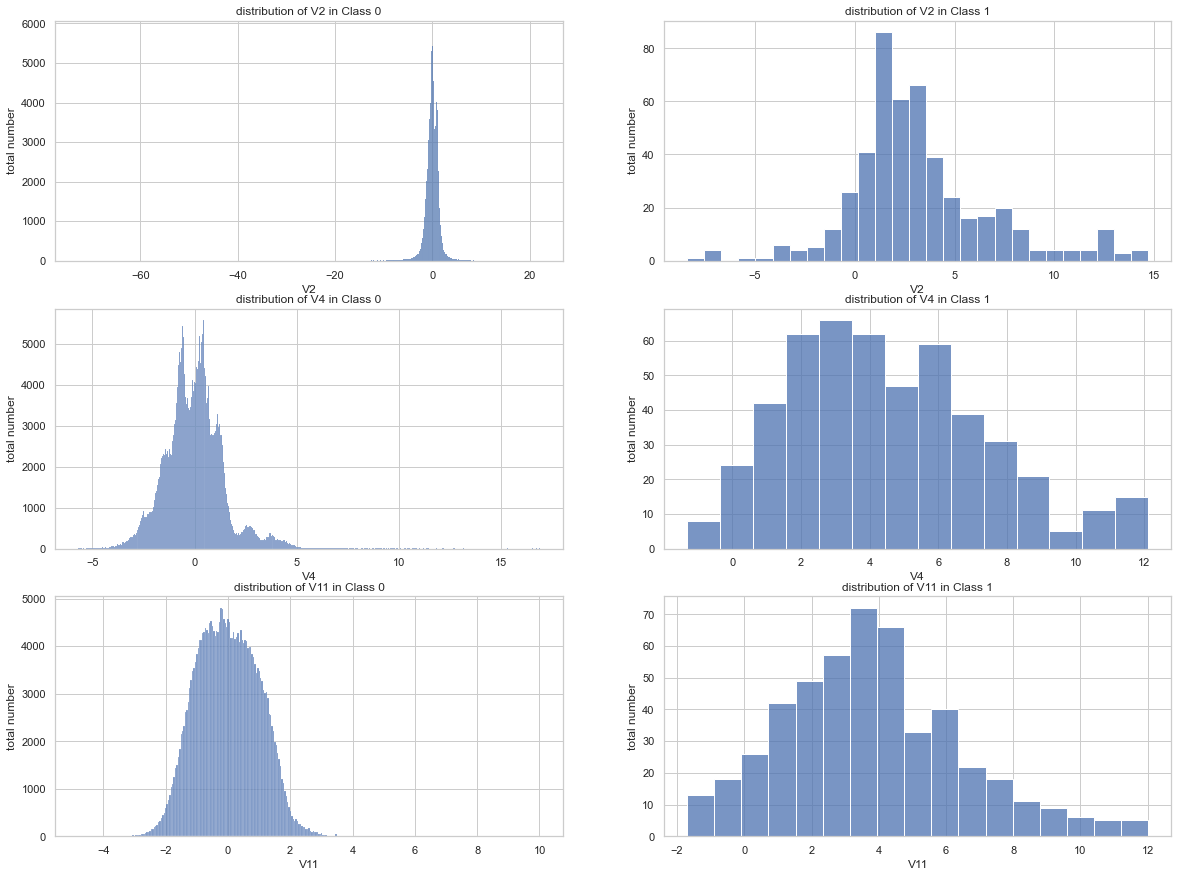

In [54]:
cor = []
for col in df.drop('Class', axis=1).columns:
    cor.append(np.corrcoef(df[col], df.Class)[0][1])
imp_features = df.drop('Class', axis=1).columns[np.argsort(np.array(cor))[-3:]]
#sns.histplot(data=df[(df[imp_features[0]] > -15) & (df[imp_features[0]] < 15) & df['Class'] == 0], x=imp_features[0])
#sns.histplot(data=df[(df[imp_features[0]] > -15) & (df[imp_features[0]] < 15) & df['Class'] == 1], x=imp_features[0])

print(imp_features)
fig, axs = plt.subplots(nrows=3, ncols=2)
fig.set_size_inches((20, 15))

sns.histplot(data=df[(df[imp_features[0]] > -15) & (df[imp_features[0]] < 15) & df['Class'] == 0], x=imp_features[0], ax=axs[0][0])
axs[0][0].set_title('distribution of V2 in Class 0')
axs[0][0].set_ylabel('total number')
sns.histplot(data=df[(df[imp_features[1]] > -15) & (df[imp_features[1]] < 15) & df['Class'] == 0], x=imp_features[1], ax=axs[1][0])
axs[1][0].set_title('distribution of V4 in Class 0')
axs[1][0].set_ylabel('total number')
sns.histplot(data=df[(df[imp_features[2]] > -15) & (df[imp_features[2]] < 15) & df['Class'] == 0], x=imp_features[2], ax=axs[2][0])
axs[2][0].set_title('distribution of V11 in Class 0')
axs[2][0].set_ylabel('total number')

sns.histplot(data=df[(df[imp_features[0]] > -15) & (df[imp_features[0]] < 15) & df['Class'] == 1], x=imp_features[0], ax=axs[0][1])
axs[0][1].set_title('distribution of V2 in Class 1')
axs[0][1].set_ylabel('total number')
sns.histplot(data=df[(df[imp_features[1]] > -15) & (df[imp_features[1]] < 15) & df['Class'] == 1], x=imp_features[1], ax=axs[1][1])
axs[1][1].set_title('distribution of V4 in Class 1')
axs[1][1].set_ylabel('total number')
sns.histplot(data=df[(df[imp_features[2]] > -15) & (df[imp_features[2]] < 15) & df['Class'] == 1], x=imp_features[2], ax=axs[2][1])
axs[2][1].set_title('distribution of V11 in Class 1')
axs[2][1].set_ylabel('total number')



Теперь давайте разделим данные. Отделите хронологически последние 20% транзакций и поделите их пополам (также хронологически, т.е. без перемешивания) на валидационные и тестовые. Это разбиение не совсем корректно (как можно было заметить, мошеннические транзакции имеют разное распределение во времени - по-хорошему, нам стоило бы выделить целые сутки записей как под валидацию, так и под тест), тем не менее, мы не сможем получить больше данных для адекватного контроля, поэтому обойдемся этим. 

In [4]:
#your code here
from sklearn.model_selection import train_test_split

X_pretrain, X_test, y_pretrain, y_test = train_test_split(df.drop(['Class', 'Time'], axis=1), df.Class, shuffle=False, test_size=0.1)
X_train, X_val, y_train, y_val = train_test_split(X_pretrain, y_pretrain, shuffle=False, test_size=1.0/9.0)


# Часть 1. Несбалансированная классификация.

**Задание 0. (1 балл)**: перед началом работы давайте поговорим о том, как мы будем оценивать качество. Классические метрики для качества классификации чаще всего "ломаются" на задачах с сильным перекосом. Чему будет равно значение accuracy для наивного предсказания (= мажорный класс для каждого объекта)? (можете не отвечать, просто подумайте)

Из курса МО-1 вам уже известно, что мы можем использовать в таких задачах `AUC-PR` и получать адекватные показатели. Можно сказать, что `AUC-PR` представляет собой матожидание `precision` по распределению, заданному выигрышем в `recall` при смене порога. 

Тем не менее, существуют и другие, не менее интересные метрики. Одной из таких метрик является коэффициент Каппа Коэна, представляющий собой нормализованную `accuracy`:

$$\kappa = \frac{p_o - p_e}{1 - p_e}$$

Данная метрика служит в качестве меры согласованности между двумя независимыми предсказателями, но ничего не знает про "верные" и "предсказанные" метки (в отличие от многих других метрик машинного обучения). Здесь $p_o$ - доля согласованных предсказаний, а $p_e$ - доля согласованных предсказаний, которая могла бы получиться при случайных ответах предсказателей. В нашем случае это работает так:

• В качестве $p_o$ берем accuracy

• В качестве $p_e$ примем следующую величину - вероятность случайного соглашения позитивных ответов (произведение долей позитивных ответов в обоих предсказаниях) плюс вероятность случайного соглашения негативных ответов (произведение долей негативных ответов в обоих предсказаниях)

Метрика принимает значения от -1 до 1, где 1 - полная согласованность, 0 - согласованность на уровне рандома, -1 - совсем плохо. Как уже говорилось, метрика не различает "верные" и "предсказанные" метки, поэтому является симметричной (можете использовать это для отладки):

In [89]:
#your code here
# Я чет так и не понял, зачем эти ячейки...
# надеюсь мне не надо писть 2 строчки кода этих методов, когда они есть в sklearn...

Еще одной метрикой в такой задаче служит коэффициент корреляции Мэтьюза, выражающийся в терминах матрицы ошибок следующим образом:

$$\text{MCC} = \frac{TP\times TN - FP \times FN}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}$$ 

Метрика принимает значения от -1 до 1, интерпретируемые аналогичным образом. 

In [ ]:
#your code here

Обратите внимание, что эти метрики вычисляются на бинаризованных предсказаниях, поэтому может иметь смысл дополнительная настройка порога бинаризации.

Давайте проверим, что наши метрики действительно подходят под задачу. Вычислите их значения для наивного предсказания (aka мажорный класс для всех объектов):

In [5]:
from sklearn.metrics import precision_recall_curve, auc, cohen_kappa_score, matthews_corrcoef

def auc_pr(y_true, y_pred):
    pr, rec, _ = precision_recall_curve(y_true, y_pred)
    return auc(x=rec, y=pr)

y_dummy = np.zeros(len(df))
def print_scores(y_true, y_pred, t):
    print(f'auc-pr value: {auc_pr(y_true, y_pred)}')
    print(f'cohen_kappa value: {cohen_kappa_score(y_true, (y_pred + t).astype(int))}')
    print(f'MCC value: {matthews_corrcoef(y_true, (y_pred + t).astype(int))}')

print_scores(df.Class, y_dummy, 0.5)

auc-pr value: 0.50086374281531
cohen_kappa value: 0.0
MCC value: 0.0
C:\Users\Danill\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Давайте запустим бейзлайн-решение для нашей задачи. С чего же начнем? Возьмите `catboost` и обучите его классификатор на наших данных (используйте все признаки). Вычислите значения всех метрик на тестовой части, для контроля переобучения используйте валидационную (здесь и далее везде, где фигурирует `catboost`). 

In [6]:
from catboost import CatBoostClassifier, Pool

In [78]:
clf = CatBoostClassifier()
clf.fit(X_train, y_train, eval_set=Pool(X_val, y_val), verbose=False)
print_scores(y_test, clf.predict_proba(X_test)[:, 1], 0.5)

auc-pr value: 0.7041793242113655
cohen_kappa value: 0.6840049779303127
MCC value: 0.6927057007478313


Если вы все сделали правильно, у вас должны были получиться значения в районе 0.7.

**Задание 1. (1 балл)**. Многие реализации методов предлагают встроенные способы для борьбы с нашей проблемой. Самое часто встречающееся решение - просто добавить вес в функции потерь для минорного класса (таким образом, ошибка на объекте минорного класса будет весить больше, чем для мажорного). В `catboost` это также реализовано, причем для бинарной задачи это можно сделать целыми двумя способами (можете выбрать любой, на свой вкус, автор задания предпочитает отдельный скейлинг для минорного класса). Чаще всего в качестве веса берется отношение числа объектов мажорного класса к числу минорного. Попробуйте обучить модель с таким скалированием и сравните метрики на тестовой части с бейзлайном.

In [85]:
clf = CatBoostClassifier(class_weights={0:1, 1:1.0 * (1-y_train).sum() / y_train.sum()})
clf.fit(X_train, y_train, eval_set=Pool(X_val, y_val), verbose=False)

In [86]:
print_scores(y_test, clf.predict_proba(X_test)[:, 1], 0.5)

auc-pr value: 0.7098518373239915
cohen_kappa value: 0.15884345035342307
MCC value: 0.2543780337160234


In [87]:
1.0 * (1-y_train).sum() / y_train.sum() #отношение размеров классов

545.3908872901678

Поскольку данный вес будет являться гиперпараметром метода, было бы опрометчиво остановиться на одном значении (тем более, с большой вероятностью у вас все сломалось). Запустите перебор для этого гиперпараметра на валидационной выборке (используйте `PR-AUC`), подберите оптимальный порог бинаризации для $\kappa$ или $\text{MCC}$. Для лучшего найденного веса и порога вычислите все метрики на тестовой части. 

При этом можете также проверить отдельное скалирование в большую сторону для мажорного класса (т.е. веса минорного сделать меньше 1) и экстремальные скалирования (т.е. веса минорного больше, чем в начале этого задания). Какой вес получился оптимальным?

In [134]:
from sklearn.model_selection import GridSearchCV, PredefinedSplit
class_weights_param_grid = [{0:1, 1:x} for x in np.logspace(-1, 3, num=10)]
ps = PredefinedSplit(test_fold=np.concatenate((np.zeros(len(y_train)), np.ones(len(y_val)))))
clf = GridSearchCV(CatBoostClassifier(), param_grid={'class_weights':class_weights_param_grid}, n_jobs=-1, cv=ps, verbose=1)
clf.fit(X_pretrain, y_pretrain, verbose=False)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 12.7min finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([0, 0, ..., 1, 1])),
             estimator=<catboost.core.CatBoostClassifier object at 0x000001905CB65AC8>,
             n_jobs=-1,
             param_grid={'class_weights': [{0: 1, 1: 0.1},
                                           {0: 1, 1: 0.2782559402207124},
                                           {0: 1, 1: 0.774263682681127},
                                           {0: 1, 1: 2.1544346900318834},
                                           {0: 1, 1: 5.994842503189409},
                                           {0: 1, 1: 16.68100537200059},
                                           {0: 1, 1: 46.41588833612777},
                                           {0: 1, 1: 129.15496650148827},
                                           {0: 1, 1: 359.38136638046257},
                                           {0: 1, 1: 1000.0}]},
             verbose=1)

In [135]:
print_scores(y_test, clf.predict_proba(X_test)[:, 1], 0.5)

auc-pr value: 0.716643440692656
cohen_kappa value: 0.7690752614163283
MCC value: 0.7754834690252622


Уже круче) подгоним порог t

In [136]:
class_weights_best = clf.best_params_['class_weights']
class_weights_best

{0: 1, 1: 16.68100537200059}

In [13]:
res = []
for t in np.linspace(0.1, 0.8, 10):
    clf = CatBoostClassifier(class_weights=class_weights_best)
    clf.fit(X_train, y_train, eval_set=Pool(X_val, y_val), verbose=False)
    res.append(cohen_kappa_score((clf.predict_proba(X_val)[:, 1] + t).astype(int), y_val) +\
        matthews_corrcoef(y_val, (clf.predict_proba(X_val)[:, 1] + t).astype(int))) #оцениваем по сумме коеффов
t_best = np.linspace(0.2, 0.8, 10)[np.argmax(res)]

In [14]:
t_best

0.46666666666666673

In [18]:
clf = CatBoostClassifier(class_weights=class_weights_best)
clf.fit(X_train, y_train, eval_set=Pool(X_val, y_val), verbose=False)
print_scores(y_test, clf.predict_proba(X_test)[:, 1], t_best)

auc-pr value: 0.6971467026708156
cohen_kappa value: 0.6518933288517803
MCC value: 0.6525113573742594


Судя по результатам, случайно угаданный порог 0.5 был +- наилучшим...
Далее работаем с ним)

**Задание 2. (1 балл)**. На самом деле, то, что мы сейчас делали, очень схоже с другой распространенной техникой - оверсэмплингом. Фактически, мы можем продублировать все объекты минорного класса и получить тот же эффект, какой был бы при использовании веса, равного 2. Тем не менее, такой подход - это лишь малая часть того, что мы можем проделать с целью повысить число объектов минорного класса. 

Для продолжения работы установим библиотеку [imbalanced-learn](https://imbalanced-learn.org/stable/):

Первый метод, которым мы воспользуемся, называется SMOTE (его вы уже разбирали на лекции). Кратко напомним суть: мы выбираем случайного кандидата среди $k$ ближайших соседей объекта минорного класса, затем берем точку на отрезке между двумя объектами (т.е. выпуклую комбинацию со случайными коэффициентами) и добавляем в выборку. 

In [ ]:
from imblearn.over_sampling import SMOTE

Используйте SMOTE для ресэмплинга обучающей выборки, на новой выборке обучите модель (вес положительных объектов скалировать не нужно). Замерьте качество на тестовой выборке (**важно!** не преобразовывайте валидационную и тестовую выборку никак - мы не хотим отслеживать качество на объектах, которых в реальности не существует). Сравните полное выравнивание выборки с частичным (т.е. таким, что баланс классов улучшается, но не достигает равенства - скажем, 1:2 и 1:10).

In [45]:
X_train_oversampled, y_train_oversampled = SMOTE().fit_resample(X_train, y_train)
clf = CatBoostClassifier()

def len_of_sample(k): #для понимания, какого размера нужна выборка для баланса 1:k 
    return int((1 + 1.0 / k) * (y_train == 0).sum())

In [46]:
clf.fit(X_train_oversampled, y_train_oversampled, eval_set=Pool(X_val, y_val), verbose=False)
print('Качество с полным выравниванием:')
print_scores(y_test, clf.predict_proba(X_test)[:, 1], 0.5)

Качество с полным выравниванием:
auc-pr value: 0.7554095010535691
cohen_kappa value: 0.6936167374627165
MCC value: 0.6972625201268832


In [47]:
clf.fit(X_train_oversampled.loc[:len_of_sample(2)-1], y_train_oversampled[:len_of_sample(2)], eval_set=Pool(X_val, y_val), verbose=False)
print('Качество с 1:2 выравниванием:')
print_scores(y_test, clf.predict_proba(X_test)[:, 1], 0.5)

Качество с 1:2 выравниванием:
auc-pr value: 0.7395327903652079
cohen_kappa value: 0.7270618976581942
MCC value: 0.7270618976581941


In [48]:
clf.fit(X_train_oversampled.loc[:len_of_sample(10)-1], y_train_oversampled[:len_of_sample(10)], eval_set=Pool(X_val, y_val), verbose=False)
print('Качество с 1:10 выравниванием:')
print_scores(y_test, clf.predict_proba(X_test)[:, 1], 0.5)

Качество с 1:10 выравниванием:
auc-pr value: 0.7377102164870721
cohen_kappa value: 0.7998608632102652
MCC value: 0.8038960655235946


In [49]:
clf.fit(X_train_oversampled.loc[:len_of_sample(100)-1], y_train_oversampled[:len_of_sample(100)], eval_set=Pool(X_val, y_val), verbose=False)
print('Качество с 1:100 выравниванием:')
print_scores(y_test, clf.predict_proba(X_test)[:, 1], 0.5)

Качество с 1:100 выравниванием:
auc-pr value: 0.7291581031263509
cohen_kappa value: 0.7498260790128315
MCC value: 0.7536088618289372


Видно, что в целом auc-pr тем больше, чем больше выравнивание. Но auc-pr это не истина последней инстанции. Остальные метрики скорее ухудшались с большим балансом. Видимо так происходит потому что данные метрики заточены на несбалансированные классы. То есть балансируя классы, мы улучшаем алгоритм, но теперь он меньше боится ошибиться на меньшем классе, поэтому получает по башке от наших метрик.
Но надо сказать, что победил все-таки здравый смысл в лице частичного балансирования: 1:10 лучший результат по мнению imblearn метрик. Думаю, тут негативные и положительные эффекты от оверсемплинга достигли равновесия.

**Бонус (1.5 балла)**. Для vanilla SMOTE существуют некоторые модификации, часть из которых была реализована в библиотеке imblearn. Во время лекций/семинаров эти модификации не рассматривались, тем не менее, мы все равно их исследуем.

Найдите статьи о следующих методах и попробуйте вкратце сформулировать, в чем их основная идея (сделайте так, чтобы человек, знакомый с машинным обучением в целом, но не слышавший конкретно про это смог понять):

BorderlineSMOTE - Идея в том, чтоб генерить новые объекты минорного класса не для любых объектов (как в SMOTE), а только для граничных. Рассмотрим у каждого минорного объекта его m ближайших соседей. И если мажорного класса больше половины, но не все, то признаем объект граничным. Дальше есть 2 вариации: оверсемплировать граничные объекты, как и в SMOTE, но по s штук среди k ближайших минорного класса или же среди любого. Где s, k - тоже гиперпараметры.

SVM-SMOTE - Мы обучаем обычный SVM с нашей разметкой. Получаем опорные вектора. Назовем область меджу ними (т.е. область недалеко от разделяющей гиперплоскости) граничной. Тогда будем генерить объекты минорного класса именно в граничной области. Идея в том, что далекие объекты и так вполнеуверенно классифицируются, поэтому не особо помогут для обучения. 

K-Means-SMOTE - Идея такая: давайте сначала с помощью k-means кластеризуем нашу выборку на k кластеров, а потом среди этих кластеров выберем те, в которых большая доля объектов минорного класса (минорный для всей выборки). И вот их-то и будем оверсэмплить, причем чем меньше в них плотность минорных классов, тем сильнее оверсэмплим.

ADASYN - для каждого объекта минорного класса считается его плотность, как доля объектов мажорного класса среди k его ближайших. Потом в зависимости от заданного баланса классов определяем, сколько мы еще хотим на оверсемплить и распределяем это кол-во по объектам минорного класса пропорционально плохности (т.е. каждому минорному приписываем свое число g - сколько сгенерим от него). Ну и дальше, как и в SMOTE генерим g от каждого минорного.

Теперь попробуйте сравнить качество всех методов на наших данных.

In [7]:
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import KMeansSMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
clf = CatBoostClassifier()
X_train_n, _, y_train_n, _ = train_test_split(X_train, y_train, train_size=0.5)

In [10]:
X_train_oversampled, y_train_oversampled = BorderlineSMOTE(sampling_strategy=0.1).fit_resample(X_train_n, y_train_n)
clf.fit(X_train_oversampled, y_train_oversampled, eval_set=Pool(X_val, y_val), verbose=False)
print('Качество BorderlineSMOTE:')
print_scores(y_test, clf.predict_proba(X_test)[:, 1], 0.5)

Качество BorderlineSMOTE:
auc-pr value: 0.7092723846772295
cohen_kappa value: 0.6805885875737472
MCC value: 0.6819815751994611


In [9]:
X_train_oversampled, y_train_oversampled = SVMSMOTE(sampling_strategy=0.1).fit_resample(X_train_n, y_train_n)
clf.fit(X_train_oversampled, y_train_oversampled, eval_set=Pool(X_val, y_val), verbose=False)
print('Качество SVMSMOTE:')
print_scores(y_test, clf.predict_proba(X_test)[:, 1], 0.5)

Качество SVMSMOTE:
auc-pr value: 0.7114866439880531
cohen_kappa value: 0.6805885875737472
MCC value: 0.6819815751994611


In [8]:
X_train_oversampled, y_train_oversampled = KMeansSMOTE(sampling_strategy=0.1, cluster_balance_threshold=0.001, n_jobs=-1).fit_resample(X_train_n, y_train_n)
clf.fit(X_train_oversampled, y_train_oversampled, eval_set=Pool(X_val, y_val), verbose=False)
print('Качество KMeansSMOTE:')
print_scores(y_test, clf.predict_proba(X_test)[:, 1], 0.5)

Качество KMeansSMOTE:
auc-pr value: 0.7036726228510501
cohen_kappa value: 0.666421265566935
MCC value: 0.6671792493946082


In [11]:
X_train_oversampled, y_train_oversampled = ADASYN(sampling_strategy=0.1, n_jobs=-1).fit_resample(X_train_n, y_train_n)
clf.fit(X_train_oversampled, y_train_oversampled, eval_set=Pool(X_val, y_val), verbose=False)
print('Качество ADASYN:')
print_scores(y_test, clf.predict_proba(X_test)[:, 1], 0.5)

Качество ADASYN:
auc-pr value: 0.7233397285250744
cohen_kappa value: 0.6805885875737472
MCC value: 0.6819815751994611


In [12]:
X_train_oversampled, y_train_oversampled = SMOTE(sampling_strategy=0.1, n_jobs=-1).fit_resample(X_train_n, y_train_n)
clf.fit(X_train_oversampled, y_train_oversampled, eval_set=Pool(X_val, y_val), verbose=False)
print('Качество SMOTE:')
print_scores(y_test, clf.predict_proba(X_test)[:, 1], 0.5)

Качество SMOTE:
auc-pr value: 0.737748985711954
cohen_kappa value: 0.6805885875737472
MCC value: 0.6819815751994611


**Задание 3. (1 балл)**. До этого момента все наши решения концентрировались на работе с минорным классом. Теперь давайте попробуем зайти с другой стороны. Может быть, для восстановления закономерностей нам не нужно столько объектов мажорного класса, и они просто засоряют нам выборку лишней информацией?

Для решения этой проблемы существуют методы андерсэмплинга. Самое простое, что можно придумать - удалять точки мажорного класса, пока мы не получим приемлемый баланс. Протестируйте следующий метод и постройте графики достигаемых значений метрик от баланса классов и от отношения размеров исходной и пересэмпленной выборки:

In [76]:
from imblearn.under_sampling import RandomUnderSampler

In [19]:
balance_space = np.logspace(base=2.0, start=0, stop=9, num=10)
# = np.array([1.0, 1.5, 5.0, 10.0, 50.0, 200.0, 500.0])
size_ratio = []
auc_pr_res = []
cohen_kappa_score_res = []
matthews_corrcoef_res = []

for k in balance_space:
    X_train_undersampled, y_train_undersampled = RandomUnderSampler(sampling_strategy=1.0 / k).fit_resample(X_train, y_train)
    size_ratio.append(1.0 * len(y_train) / len(y_train_undersampled))
    clf = CatBoostClassifier()
    clf.fit(X_train_undersampled, y_train_undersampled, eval_set=Pool(X_val, y_val), verbose=False)
    y_pred = clf.predict_proba(X_test)[:, 1]
    auc_pr_res.append(auc_pr(y_test, y_pred))
    cohen_kappa_score_res.append(cohen_kappa_score(y_test, (y_pred + 0.5).astype(int)))
    matthews_corrcoef_res.append(matthews_corrcoef(y_test, (y_pred + 0.5).astype(int)))
    print(f'{k} done')

1.0 done
2.0 done
4.0 done
8.0 done
16.0 done
32.0 done
64.0 done
128.0 done
256.0 done
512.0 done


ipykernel_launcher:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


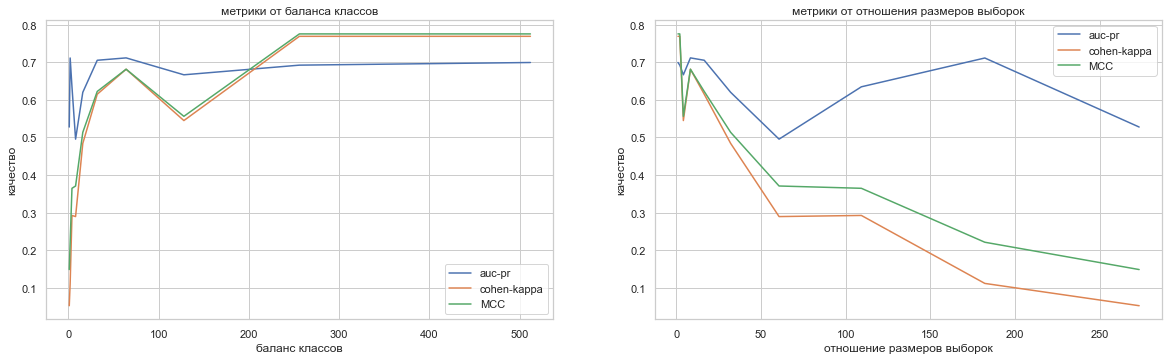

In [36]:
#plt.figure(figsize=(16, 10))
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches((20, 5.5))

ax1.plot(balance_space, auc_pr_res, label='auc-pr')
ax1.plot(balance_space, cohen_kappa_score_res, label='cohen-kappa')
ax1.plot(balance_space, matthews_corrcoef_res, label='MCC')
ax1.legend()
ax1.set_xlabel('баланс классов')
ax1.set_ylabel('качество')
ax1.set_title('метрики от баланса классов')

ax2.plot(size_ratio, auc_pr_res, label='auc-pr')
ax2.plot(size_ratio, cohen_kappa_score_res, label='cohen-kappa')
ax2.plot(size_ratio, matthews_corrcoef_res, label='MCC')
ax2.legend()
ax2.set_xlabel('отношение размеров выборок')
ax2.set_ylabel('качество')
ax2.set_title('метрики от отношения размеров выборок')

fig.show()

Даже такой наивный подход может дать относительно неплохие результаты и улучшить наши метрики. Тем не менее, сейчас мы никак не используем информацию о распределении объектов в выборке. Оказывается, что даже относительно простые эвристические правила могут заметно поднять нам качество - например, мы можем при отбрасывании использовать близость отдельных объектов мажорного класса к минорному и отбрасывать самые близкие. Протестируйте алгоритм [Near-Miss](https://www.site.uottawa.ca/~nat/Workshop2003/jzhang.pdf) на наших данных и постройте графики, аналогичные предыдущему пункту (также добавьте график с зависимостью качества от числа соседей).

In [42]:
from imblearn.under_sampling import NearMiss
balance_space = np.logspace(base=2.0, start=0, stop=9, num=10)
size_ratio = []
auc_pr_res = []
cohen_kappa_score_res = []
matthews_corrcoef_res = []

for k in balance_space:
    d = {1:(y_train == 1).sum(), 0:int(k * (y_train == 1).sum())}
    X_train_undersampled, y_train_undersampled = NearMiss(sampling_strategy=d).fit_resample(X_train, y_train)
    size_ratio.append(1.0 * len(y_train) / len(y_train_undersampled))
    clf = CatBoostClassifier()
    clf.fit(X_train_undersampled, y_train_undersampled, eval_set=Pool(X_val, y_val), verbose=False)
    y_pred = clf.predict_proba(X_test)[:, 1]
    auc_pr_res.append(auc_pr(y_test, y_pred))
    cohen_kappa_score_res.append(cohen_kappa_score(y_test, (y_pred + 0.5).astype(int)))
    matthews_corrcoef_res.append(matthews_corrcoef(y_test, (y_pred + 0.5).astype(int)))
    print(f'{k} done')

1.0 done
2.0 done
4.0 done
8.0 done
16.0 done
32.0 done
64.0 done
128.0 done
256.0 done
512.0 done


In [44]:
k_best = balance_space[np.argmax(auc_pr_res)]
k_best

16.0

In [45]:
neighbors = [1, 2, 3, 5, 10, 30, 50]

auc_pr_res_of_n = []
cohen_kappa_score_res_of_n = []
matthews_corrcoef_res_of_n = []

for n in neighbors:
    d = {1:(y_train == 1).sum(), 0:int(k_best * (y_train == 1).sum())}
    X_train_undersampled, y_train_undersampled = NearMiss(sampling_strategy=d, n_neighbors=n).fit_resample(X_train, y_train)
    clf = CatBoostClassifier()
    clf.fit(X_train_undersampled, y_train_undersampled, eval_set=Pool(X_val, y_val), verbose=False)
    y_pred = clf.predict_proba(X_test)[:, 1]
    auc_pr_res_of_n.append(auc_pr(y_test, y_pred))
    cohen_kappa_score_res_of_n.append(cohen_kappa_score(y_test, (y_pred + 0.5).astype(int)))
    matthews_corrcoef_res_of_n.append(matthews_corrcoef(y_test, (y_pred + 0.5).astype(int)))
    print(f'{n} done')

1 done
2 done
3 done
5 done
10 done
30 done
50 done


ipykernel_launcher:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


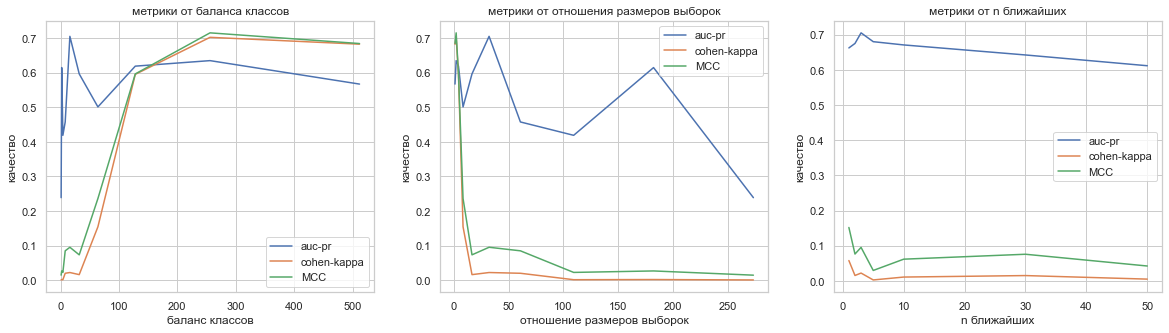

In [46]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches((20, 5))

ax1.plot(balance_space, auc_pr_res, label='auc-pr')
ax1.plot(balance_space, cohen_kappa_score_res, label='cohen-kappa')
ax1.plot(balance_space, matthews_corrcoef_res, label='MCC')
ax1.legend()
ax1.set_xlabel('баланс классов')
ax1.set_ylabel('качество')
ax1.set_title('метрики от баланса классов')

ax2.plot(size_ratio, auc_pr_res, label='auc-pr')
ax2.plot(size_ratio, cohen_kappa_score_res, label='cohen-kappa')
ax2.plot(size_ratio, matthews_corrcoef_res, label='MCC')
ax2.legend()
ax2.set_xlabel('отношение размеров выборок')
ax2.set_ylabel('качество')
ax2.set_title('метрики от отношения размеров выборок')

ax3.plot(neighbors, auc_pr_res_of_n, label='auc-pr')
ax3.plot(neighbors, cohen_kappa_score_res_of_n, label='cohen-kappa')
ax3.plot(neighbors, matthews_corrcoef_res_of_n, label='MCC')
ax3.legend()
ax3.set_xlabel('n ближайших')
ax3.set_ylabel('качество')
ax3.set_title('метрики от n ближайших')

fig.show()

Подведем итоги, хоть в задании и не требовалось. Чисто на глазок, учитывая метрики, максимальный баланс классов - 50. (изначальный 500), т.е. методы имеют смысл. Другое дело, что они все дают примерно схожие auc-pr около 0.72, немного разные другие метрики (ну потому что они в отличии от auc-pr чувствительны к балансу классов). Поэтому да, делаю вывод: лучше всего использовать бояны типа SMOTE и рандома и не выпендриваться)0.

**Бонус (1 балл)**. imblearn также предлагает много различных методов для андерсэмплинга. Выберите что-нибудь еще из предлагаемого на свой вкус, опишите идею метода и протестируйте его.

**Бонус (2 балла)**. Сможете ли вы с помощью комбинации любых методов оверсэмплинга, андерсэмплинга и классификации набрать 0.8 на всех трех метриках?

Ответ: нет

(жду свои 2 балла)

Ландно, первый бонус можно и сделать. 

ClusterCentroids - выглядит максимально мутно (как и все по этой теме). Но идея такая. Предположим, после андерсэмплинга мы хотим оставить N объектов мажорного класса (т.е. если изначально M минорного было, то получим баланс N/M). Тогда запустим k-means с n_neibours=N и получим N классов. Возьмем центры этих классов за новые объекты мажорного класса (а старые выкинем). Вот. Спойлер: работал полчаса, качество отстой.

In [16]:
from imblearn.under_sampling import ClusterCentroids
X_train_undersampled, y_train_undersampled = ClusterCentroids(sampling_strategy=0.1).fit_resample(X_train_n, y_train_n)
clf.fit(X_train_undersampled, y_train_undersampled, eval_set=Pool(X_val, y_val), verbose=False)
print('Качество ClusterCentroids:')
print_scores(y_test, clf.predict_proba(X_test)[:, 1], 0.5)

Качество ClusterCentroids:
auc-pr value: 0.6654265911216803
cohen_kappa value: 0.32572277578615927
MCC value: 0.39052915287019085


# Часть 2. Поиск аномалий. 

Как вы могли заметить, методы балансировки выборок очень часто могут привести к не самым лучшим результатам из-за того, что они по сути искажают информацию о реальном распределении данных - в реальности обычно требуется долгий подбор в принципе работоспособных для задачи методов и их аккуратная настройка. 

Теперь давайте попробуем слегка сменить постановку задачи и переключиться на задачу "одноклассовой" классификации, то есть - поиска *аномалий* в выборке. В общем-то, это вполне согласуется с нашей областью работы - мы действительно можем назвать мошеннические транзакции аномальньми (как интуитивно, так и на основании наблюдаемой балансировки данных). 

Стоит отметить, что методы обнаружения аномалий чаще всего относятся к классу методов обучения без учителя. Это дает некоторый положительный эффект - нам не обязательно нужно тратить время на разметку данных (тем не менее, для контроля качества какую-то часть разметить все-таки придется). Впрочем, чаще всего перфоманс таких методов оказывается заметно хуже, чем у честного обучения с учителем (если мы можем себе его позволить).



**Задание 4. (3 балла).** На занятиях вы разбирали схожий с Random Forest подход для детекции аномалий без известной разметки данных, называемый Isolation Forest. Напомним суть: на этапе обучения мы создаем ансамбль из решающих деревьев, в котором признак и порог на каждую вершину подбираются случайно. Затем мы считаем для объектов оценку аномальности через длину пути до соответствующего листа в каждом дереве.

В данном задании вам предлагается реализовать модификацию данного алгоритма, известную как Extended Isolation Forest. В ней мы на каждом шаге будем определять не порог для признака, а полноценную случайную гиперплоскость, разбивающую выборку на 2 части. С детальным описанием вы можете ознакомиться [здесь](https://arxiv.org/pdf/1811.02141.pdf).

Ниже приведен шаблон кода. Постарайтесь работать в его рамках (минорные изменения вполне допустимы, главное не переворачивайте всю структуру с ног на голову). 

**NB**: будем считать, что в нашем датасете нет категориальных признаков - можете не заморачиваться с их обработкой (но в общем случае, это будет важно).

**Советы**:
 - Численные признаки лучше предобработать надлежащим образом.
 - Возможно, вам поможет выбрасывание некоторых признаков.
 - Внимательно следите за знаками.
 - Не игнорируйте документирующие строки.
 - Вероятнее всего, вы не сможете приблизиться по качеству к supervised-решениям. Если у вас не получается это сделать (но вы уверены в своей правоте), не стоит тратить слишком много времени на поиск ошибок.



**Бонусы (каждый по 0.5)**:
- Сделайте ваш EIF параллельным (`multiprocessing`, `joblib`).
- Добавьте возможность откатиться к дефолтному варианту Isolation Forest. (порассуждайте, как можно реализовать это в данной модели?):


In [6]:
import multiprocessing as mp
from joblib import Parallel, delayed
def c_factor(n):
    """
    Computes average path length for an unsuccessful search in a binary search tree.
    Params:
        n: int - number of data points for BST
    """
    #your code here
    return 2.0 * np.arange(1, n).sum() - 2.0 * (n-1) / n

def calc_height(X, depth, node, IF):
    """
    Calculates anomaly scores for sample in a recursive manner.
    Params:
        X: np.array - current sample, available to node
        
        depth: int - path length up to current node
        
        node: Node - current tree node
        
    Returns:
        height: int, float or np.array - heighths for sample
    """
    #your code here
    heights = np.zeros(X.shape[0])
    if node.kind == 'external':
        return heights + depth
    if not IF:
        heights[(X - node.b) @ node.w <= 0] = calc_height(X[(X - node.b) @ node.w <= 0], depth + 1, node.left, IF)
        heights[(X - node.b) @ node.w > 0] = calc_height(X[(X - node.b) @ node.w > 0], depth + 1, node.right, IF)
    else:
        heights[X[node.w] <= node.b] = calc_height(X[X[node.w] <= node.b], depth+1, node.left, IF)
        heights[X[node.w] > node.b] = calc_height(X[X[node.w] > node.b], depth+1, node.right, IF)
    return heights

class Node(object):
    """
    A single node object for each tree. Contains information on height, current data,
    splitting hyperplane and children nodes.
    
    Attributes:
        X: np.array - data available to current node
        size: int - length of available data
        
        depth: int - depth of node

        left: Node - left child
        right: Node - right child

        kind: str - either "internal" or "external", indicates the type of current node

        w: np.array - normal vector for the splitting hyperplane
        b: float - intercept term for the splitting hyperplane
    """
    def __init__(self, X, depth, left, right, kind, w, b):
        """
        Node(h, left, right, kind, w, b)
        Represents the node object.
        
        Params:
            X: np.array - data available to current node
            depth: int - depth of node
            
            left: Node - left child
            right: Node - right child
            
            kind: str - either "internal" or "external", indicates the type of current node
            
            w: np.array - normal vector for the splitting hyperplane
            b: float - intercept term for the splitting hyperplane
            
        """
        self.size = len(X)
        
        self.depth = depth
        
        self.left = left
        self.right = right
        
        self.kind = kind
    
        self.w = w
        self.b = b
    
    def __repr__(self):
        """
        For convenience only.
        """
        return f"Node(size={self.size}, depth={self.depth}, kind={self.kind})"

class RandomizedTree(object):
    """
    Single randomized tree object. Stores root and its depth (tree is built recursively).
    Attributes:
        depth: int - current tree depth
        
        max_depth: int - maximum tree depth
        
        root: Node - root node 

        internal_count: int - number of internal nodes

        external_count: int - number of external nodes
        
    """
    def __init__(self, X, max_depth, IF):
        """
        Single randomized tree object. Stores root and its depth (tree is built recursively).
        Params:
            X: np.array - train sample
            max_depth: int - maximum tree depth

        """
        self.depth = 0
        self.IF = IF
        self.max_depth = max_depth
        
        self.internal_count = 0
        self.external_count = 0

        self.root = self.grow(X, 0)
        
    def __repr__(self):
        """
        For convenience only.
        """
        
        return f"RandomizedTree(depth={self.depth}, max_depth={self.max_depth}, n_internal={self.internal_count}, n_external={self.external_count})"

        
        
    def grow(self, X, depth):
        """
        Grow tree in a recursive manner.
        Params:
            X: np.array - available train sample
            
            depth: int - current tree depth
            
        Returns:
            node: Node - a trained node with separating hyperplane data.
                         Node provides access to children if necessary (these are built recursively)
        """
        #your code here
        if len(X) <= 1 or (self.max_depth is not None and depth == self.max_depth):
            self.external_count += 1
            return Node(X, depth, None, None, 'external', None, None)
        if not self.IF:
            w = np.random.normal(size=X.shape[1])
            b = np.random.uniform(low=np.min(X, axis=0), high=np.max(X, axis=0))
            left = self.grow(X[(X - b) @ w <= 0], depth+1)
            right = self.grow(X[(X - b) @ w > 0], depth+1)
        else:
            w = np.random.choice(X.columns)
            b = np.random.uniform(low=np.min(X[w]), high=np.max(X[w]))
            left = self.grow(X[X[w] <= b], depth+1)
            right = self.grow(X[X[w] > b], depth+1)
        self.internal_count += 1

        return Node(X, depth, left, right, 'internal', w, b)

    # def score_samples(self, X):
    #     """
    #     Calculate anomaly scores for given data. You may utilize outer function `calc_height`.
    #     Params:
    #         X: np.array - data to be evaluated
            
    #     Returns:
    #         scores: np.array - estimated anomaly scores
    #     """
    #     #your code here
    #     calc_height(X, 0, self.root)

    #     return scores
        
    
class ExtendedIsolationForest(object):
    """
    Extended Isolation Forest object. Stores training data and trained randomized trees.
    Attributes:
        n_trees: int - number of Randomized Trees
        
        max_depth: int - maximum depth of each tree
        
        subsample_rate: float - draw `subsample_rate * X.shape[0]` samples for each tree
        
        trees: list - container for trained trees 
        
        contamination: float - estimated fraction of anomaly samples in data. Used for thresholding

        IF: bool - whether to use default isolation forest

        n_jobs: int - number of processors to use. "-1" means usage of all the processors
        
    """
    
    def __init__(self, n_trees=20, subsample_rate=0.2, max_depth=None, contamination=0.01, IF=False, n_jobs=-1):
        """
        Extended Isolation Forest object. Stores training data and trained randomized trees.
        Params:
            n_trees: int - number of Randomized Trees

            subsample_rate: float - draw `subsample_rate * X.shape[0]` samples for each tree

            max_depth: int or None - maximum depth of each tree. Defaults to ceil(log_2(subsample_size)) if not provided

            contamination: float - estimated fraction of anomaly samples in data. Used for thresholding

        """
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.subsample_rate = subsample_rate
        self.trees = []
        self.contamination = contamination
        self.is_fit = False
        self.threshold = None
        self.IF = IF
        self.n_jobs = n_jobs
        if n_jobs == -1:
            self.n_jobs = mp.cpu_count()
        self.n_fit_objects = None
        
    def __repr__(self):
        """For convenience only."""
        
        return f"ExtendedIsolationForest(n_trees={self.n_trees}, max_depth={self.max_depth}, subsample_rate={self.subsample_rate}, contamination={self.contamination}, is_fit={self.is_fit})"
        
    def fit(self, X):
        """
        Fit EIF to new data.
        Params:
            X: np.array - 2d array of samples
        """
        #your code here
        # if self.max_depth is None:
        #     self.max_depth = np.log2(len(X) * self.subsample_rate)

        # for i in tqdm(range(self.n_trees)):
        #     ind = np.random.choice(np.arange(len(X)), int(self.subsample_rate * len(X)), replace=False)
        #     self.trees.append(RandomizedTree(X.iloc[ind], self.max_depth, self.IF))
        # self.threshold = np.sort(self.score_samples(X))[int(X.shape[0] * (1 - self.contamination))]
        # self.is_fit = True
        # return self

        self.n_fit_objects = len(X)
        def generate_tree(i):
            ind = np.random.choice(np.arange(X.shape[0]), int(self.subsample_rate * X.shape[0]), replace=False)
            return RandomizedTree(X.iloc[ind], self.max_depth, self.IF)

        self.trees = Parallel(n_jobs=self.n_jobs)(delayed(generate_tree)(i) for i in tqdm(range(self.n_trees)))
        self.threshold = np.sort(self.score_samples(X))[::-1][int(X.shape[0] * self.contamination)]
        self.is_fit = True
        return self
    
    def score_samples(self, X):
        """
        Estimate (normalized) anomaly score for each given sample
        Params:
            X: np.array - new samples

        Returns:
            scores: np.array - anomaly scores (larger value means higher probability of a sample being an outlier)
        """
        #your code here
        # eh = np.zeros(len(X))
        # for tree in tqdm(self.trees):
        #     eh += calc_height(X, 0, tree.root, self.IF)
        # eh /= self.n_trees
        # return np.power(2, -eh / c_factor(int(len(X) * self.subsample_rate)))
        eh = np.array(Parallel(n_jobs=self.n_jobs)(delayed(lambda x: calc_height(X, 0, x, self.IF))(t.root) for t in tqdm(self.trees))).mean(axis=0)
        return np.power(2, -eh / c_factor(int(self.n_fit_objects * self.subsample_rate)))
    
    def predict(self, X):
        """
        Predict if given samples are outliers.
        Params:
            X: np.array - new samples

        Returns:
            labels: np.array - anomaly labels (1 for outliers, 0 for inliers)
        """
        #your code here
        
        if not self.is_fit:
            return None
        return (self.score_samples(X) > self.threshold).astype(int)


**Задание 5. (1 балл).** Протестируйте вашу реализацию EIF и подберите оптимальные гиперпараметры (наш метод не использует разметку, поэтому можете попробовать делать это на обучающей выборке). Сравните ее с обычным IF из `sklearn` (желательно делать это на одних и тех же параметрах). Удалось ли сделать лучше? Кажется, улучшение незначимо, но да

In [7]:
from imblearn.under_sampling import RandomUnderSampler
X_train_undersampled, y_train_undersampled = RandomUnderSampler(sampling_strategy=1.0 / 50).fit_resample(X_train, y_train)
X_test_undersampled, y_test_undersampled = RandomUnderSampler(sampling_strategy=1.0 / 50).fit_resample(X_test, y_test)
ind_train = np.random.choice(np.arange(X_train_undersampled.shape[0]), 3000, replace=False)
X_subtrain = X_train_undersampled.iloc[ind_train]
y_subtrain = y_train_undersampled.iloc[ind_train]
ind_test = np.random.choice(np.arange(X_test_undersampled.shape[0]), 900, replace=False)
X_subtest = X_test_undersampled.iloc[ind_test]
y_subtest = y_test_undersampled.iloc[ind_test]


In [158]:
clf = ExtendedIsolationForest(n_trees=20, subsample_rate=0.2, max_depth=11, IF=False, contamination=0.02)
clf.fit(X_subtrain)
y_pred = clf.predict(X_subtest)
print_scores(y_subtest, y_pred, 0.5)

100%|██████████| 20/20 [00:01<00:00, 12.16it/s]
auc-pr value: 0.008888888888888889
cohen_kappa value: -0.018658252160790312
MCC value: -0.018667147870458478


In [8]:
# подбираем max_depth
max_depth_grid = [3, 6, 15, 30]
for k in max_depth_grid:
    clf = ExtendedIsolationForest(n_trees=20, subsample_rate=0.6, max_depth=k, IF=False, contamination=0.1)
    clf.fit(X_subtrain)
    y_pred = clf.predict(X_subtest)
    print()
    print(f'{k} done!')
    print(f'auc-pr: {auc_pr(y_subtest, y_pred)}')

  0%|          | 0/20 [00:00<?, ?it/s]
3 done!
auc-pr: 0.01
  0%|          | 0/20 [00:00<?, ?it/s]
6 done!
auc-pr: 0.13712121212121212
  0%|          | 0/20 [00:00<?, ?it/s]
15 done!
auc-pr: 0.2991176470588235
100%|██████████| 20/20 [00:20<00:00,  1.01s/it]

30 done!
auc-pr: 0.26381381381381375


In [167]:
# подбираем subsample_rate
subsample_rate_grid = [0.1, 0.4, 0.6, 0.8]
for k in subsample_rate_grid:
    clf = ExtendedIsolationForest(n_trees=20, subsample_rate=k, max_depth=11, IF=False, contamination=0.1)
    clf.fit(X_subtrain)
    y_pred = clf.predict(X_subtest)
    print()
    print(f'{k} done!')
    print(f'auc-pr: {auc_pr(y_subtest, y_pred)}')

  0%|          | 0/20 [00:00<?, ?it/s]
0.1 done!
auc-pr: 0.22398339060710196
  0%|          | 0/20 [00:00<?, ?it/s]
0.4 done!
auc-pr: 0.30444444444444446
  0%|          | 0/20 [00:00<?, ?it/s]
0.6 done!
auc-pr: 0.4207004830917874
100%|██████████| 20/20 [00:01<00:00, 13.44it/s]

0.8 done!
auc-pr: 0.3809027777777778


In [16]:
#побдираем contamination
contamination_grid = [0.01, 0.05, 0.12, 0.2]
for k in contamination_grid:
    clf = ExtendedIsolationForest(n_trees=20, subsample_rate=0.6, max_depth=11, IF=False, contamination=k)
    clf.fit(X_subtrain)
    y_pred = clf.predict(X_subtest)
    print()
    print(f'{k} done!')
    print(f'auc-pr: {auc_pr(y_subtest, y_pred)}')

  0%|          | 0/20 [00:00<?, ?it/s]
0.01 done!
auc-pr: 0.01
  0%|          | 0/20 [00:00<?, ?it/s]
0.05 done!
auc-pr: 0.26305555555555554
  0%|          | 0/20 [00:00<?, ?it/s]
0.12 done!
auc-pr: 0.348451536643026
100%|██████████| 20/20 [00:01<00:00, 11.96it/s]

0.2 done!
auc-pr: 0.39031165311653115


In [10]:
#побдираем n_trees
n_trees_grid = [10, 30, 50]
for k in n_trees_grid:
    clf = ExtendedIsolationForest(n_trees=k, subsample_rate=0.6, max_depth=11, IF=False, contamination=0.2)
    clf.fit(X_subtrain)
    y_pred = clf.predict(X_subtest)
    print()
    print(f'{k} done!')
    print(f'auc-pr: {auc_pr(y_subtest, y_pred)}')

  0%|          | 0/30 [00:00<?, ?it/s]
10 done!
auc-pr: 0.44833333333333336
  0%|          | 0/50 [00:00<?, ?it/s]
30 done!
auc-pr: 0.4847712418300653
100%|██████████| 50/50 [00:52<00:00,  1.04s/it]

50 done!
auc-pr: 0.39290674603174597


In [13]:
# склерновский
from sklearn.ensemble import IsolationForest
clf = IsolationForest(n_estimators=20, max_samples=0.6, contamination=0.2, n_jobs=-1)
clf.fit(X_subtrain)
#y_pred0 = clf.predict(X_subtest)
y_pred1 = 1 - clf.predict(X_subtest)
#print_scores(y_subtest, y_pred0, 0.5)
print_scores(y_subtest, y_pred1, 0.5)

auc-pr value: 0.4478608923884514
cohen_kappa value: 0.03716469354113594
MCC value: 0.08746222542233967


In [14]:
# деволтный IF
clf = ExtendedIsolationForest(n_trees=20, subsample_rate=0.6, max_depth=11, IF=True, contamination=0.2)
clf.fit(X_subtrain)
y_pred = clf.predict(X_subtest)
print_scores(y_subtest, y_pred, 0.5)

100%|██████████| 20/20 [00:00<00:00, 33.18it/s]
auc-pr value: 0.4484538152610442
cohen_kappa value: 0.07796451914098979
MCC value: 0.17776633472978676


In [17]:
# оптимальный EIF
clf = ExtendedIsolationForest(n_trees=20, subsample_rate=0.6, max_depth=11, IF=False, contamination=0.2)
clf.fit(X_subtrain)
y_pred = clf.predict(X_subtest)
print_scores(y_subtest, y_pred, 0.5)

100%|██████████| 20/20 [00:01<00:00, 12.00it/s]
auc-pr value: 0.42444444444444446
cohen_kappa value: 0.08925318761384349
MCC value: 0.18389242812245682


Возможно, ваш алгоритм выдал большие оценки объектам с негативной разметкой. Постарайтесь выбрать несколько таких объектов и доступно объяснить (= с кодом и графиками), почему так вышло:

In [29]:
#пара статистик
print()
print(y_pred.mean())
print(((y_pred == 1) & (y_subtest == 1)).mean())
clf.score_samples(X_subtest[y_subtest == 0]).mean()

  0%|          | 0/20 [00:00<?, ?it/s]
0.23333333333333334
0.015555555555555555
100%|██████████| 20/20 [00:02<00:00,  9.98it/s]


0.9999976702187059

In [32]:
-np.log2(clf.threshold) * c_factor(int(clf.n_fit_objects * 0.6))

10.950000000074809

In [33]:
for t in clf.trees:
    print(t.internal_count, end=' ')
    print(t.external_count)

117 118
247 248
50 51
73 74
177 178
252 253
192 193
149 150
227 228
125 126
160 161
189 190
97 98
151 152
164 165
118 119
184 185
236 237
196 197
145 146


Что значит эта инфа? Это значит, что для того, чтоб объект попал в аутлаер, он должен гулять по деревьям в среднем меньше 10.95 раз. Ясен пень, что любое случайное отсечение объекта в изолированную вершину будет тогда означать позитивный класс для него. А учитывая как мы рандомим с гиперплоскостью, в изоляцию может попасть любой объект почти равновероятно. Это подтверждается кол-вами внутренних и внешних вершин (одно на 1 больше другого), которые говорят о том, что у нас все доходят до max_depthПоэтому все scores получаются очень близкими к 1, т.к. мы ограничили достаточно сильно max_depth и почти все доходят до конца. Но если снять это ограничение, то либо это не понравится auc-pr, тк мы будем по сути рандомить, либо надо сильно поднимать n_trees и max_depth, на что мой ноут уже не готов.

**Задание 6. (1 балл).** `sklearn` также предлагает нам и другие методы для поиска аномалий. В этом задании мы предлагаем вам сделать следующее:

Для начала попробуйте использовать методы Local Outlier Factor и One-Class SVM. Сравните результаты с IF и EIF.  

In [40]:
from sklearn.neighbors import LocalOutlierFactor
y_pred = (1 - LocalOutlierFactor(n_jobs=-1).fit_predict(X_subtrain)) // 2
print_scores(y_subtrain, y_pred, 0.5)

auc-pr value: 0.5102276524644945
cohen_kappa value: 0.4017957104910763
MCC value: 0.44588268940589537


In [43]:
from sklearn.svm import OneClassSVM
y_pred = (1 - OneClassSVM(gamma='auto').fit_predict(X_subtrain)) // 2
print_scores(y_subtrain, y_pred, 0.5)

auc-pr value: 0.4895873015873016
cohen_kappa value: 0.03146930869137232
MCC value: 0.11926569370056186


Ну в общем да. Метрики все еще не очень, но даже на дефолтных параметрах всяко лучше, чем IF и EIF 

У вас началась депрессия из-за плохих метрик? Не беда! Сейчас давайте сделаем так: все методы, опробованные в этой части, попробуем задействовать для создания дополнительных признаков в данных. Проделайте это (не забудьте, что обучаться здесь нужно на трейне). Теперь возьмите лучшую модель из предыдущей части и обучите на новых данных. Смогли ли unsupervised-методы повысить вам качество?

In [46]:
# так было
from catboost import CatBoostClassifier, Pool
clf = CatBoostClassifier()
clf.fit(X_train, y_train, eval_set=Pool(X_val, y_val), verbose=False)
print_scores(y_test, clf.predict_proba(X_test)[:, 1], 0.5)

auc-pr value: 0.7041793242113655
cohen_kappa value: 0.6840049779303127
MCC value: 0.6927057007478313


In [63]:
#в качестве не сильно потеряли, а объектов меньше в разы
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import RandomUnderSampler
X_train_r, y_train_r = RandomUnderSampler(sampling_strategy=0.02).fit_resample(X_train, y_train)
clf.fit(X_train_r, y_train_r, eval_set=Pool(X_val, y_val), verbose=False)
print_scores(y_test, clf.predict_proba(X_test)[:, 1], 0.5)

auc-pr value: 0.7164273776401223
cohen_kappa value: 0.6664032552651696
MCC value: 0.666568120598483


In [66]:
lof = LocalOutlierFactor(novelty=True, n_jobs=-1).fit(X_train_r)

In [69]:
svm = OneClassSVM(gamma='auto').fit(X_train_r)

In [71]:
IF = IsolationForest(n_estimators=20, max_samples=0.6, contamination=0.2, n_jobs=-1).fit(X_train_r)

In [72]:
EIF = ExtendedIsolationForest(n_trees=20, subsample_rate=0.6, max_depth=11, IF=False, contamination=0.2).fit(X_train_r)

100%|██████████| 20/20 [00:03<00:00,  6.29it/s]


In [76]:
lof_col = lof.predict(X_train_r)
print('lof done!')
svm_col = svm.predict(X_train_r)
print('svm done!')
if_col = IF.predict(X_train_r)
print('IF done!')
eif_col = EIF.predict(X_train_r)
print('EIF done!')
X_train_r['lof'] = lof_col
X_train_r['svm'] = svm_col
X_train_r['if'] = if_col
X_train_r['eif'] = eif_col

lof done!
svm done!
100%|██████████| 20/20 [00:04<00:00,  4.52it/s]
EIF done!


In [77]:
lof_col = lof.predict(X_val)
print('lof done!')
svm_col = svm.predict(X_val)
print('svm done!')
if_col = IF.predict(X_val)
print('IF done!')
eif_col = EIF.predict(X_val)
print('EIF done!')
X_val['lof'] = lof_col
X_val['svm'] = svm_col
X_val['if'] = if_col
X_val['eif'] = eif_col

lof done!
svm done!
100%|██████████| 20/20 [00:03<00:00,  5.72it/s]
EIF done!
ipykernel_launcher:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipykernel_launcher:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipykernel_launcher:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

In [78]:
lof_col = lof.predict(X_test)
print('lof done!')
svm_col = svm.predict(X_test)
print('svm done!')
if_col = IF.predict(X_test)
print('IF done!')
eif_col = EIF.predict(X_test)
print('EIF done!')
X_test['lof'] = lof_col
X_test['svm'] = svm_col
X_test['if'] = if_col
X_test['eif'] = eif_col

lof done!
svm done!
100%|██████████| 20/20 [00:04<00:00,  4.66it/s]
EIF done!


In [79]:
clf = CatBoostClassifier()
clf.fit(X_train_r, y_train_r, eval_set=Pool(X_val, y_val), verbose=False)
print_scores(y_test, clf.predict_proba(X_test)[:, 1], 0.5)

auc-pr value: 0.7014974679667609
cohen_kappa value: 0.6664032552651696
MCC value: 0.666568120598483


Ну

Грех не продолбать целый вечер на нулевое повышение качества

Пошел на выставку заплакивать горе

**Бонус. (0.5 балла).**

Ну что ж, вот и подошла к концу домашка по методам борьбы с несбалансированными данными. Надеемся, вы не сильно устали и вам еще не противно. А знаете, чье творчество тоже нельзя назвать сбалансированным? В течение своей жизни Роберт Фальк писал в самых разных жанрах, то ломая все традиции, то, наоборот, продвигая их в массы. В связи с этим мы рекомендуем ознакомиться с его работами на [выставке](https://www.tretyakovgallery.ru/exhibitions/robert-falk/) в Новой Третьяковке. Там вы сможете пронаблюдать весь творческий путь одного из знаковых советских живописцев.

Данный номер будет зачтен, если вы предоставите небольшой фотоотчет и расскажете, что вам удалось понять после посещения экспозиции.


**Бонус. (0.1 балла).**

При сдаче проверяющий запустит следующую клетку один раз. Если она даст положительный результат, вы получите 0.1 бонусных балла. Если она даст отрицательный результат, вы получите -0.1 бонусных балла. Если вы получите ровно 0, то мы посчитаем вас невероятно везучим человеком и в качестве поощрения зачтем теорминимум на коллоквиуме. 

Если вы хотите отказаться от сдачи данного задания, допишите "хочу" после двоеточия: давайте сразу на балл играть! Че как лохи

Ниже вы можете попрактиковаться и оценить ваши силы (изменять код ячейки запрещается!)

In [53]:
import numpy as np

np.random.randn()

0.8546414887022463